In [1]:
import geopandas as gpd

# Use a raw string (r'...') for Windows paths to avoid issues with backslashes
gpkg_filepath = r'resa_girasole_2022.gpkg'
gdf= gpd.read_file(gpkg_filepath)

In [2]:
gdf.head()

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,NaN,POINT (1333142.685 5597543.903)
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,NaN,POINT (1333141.706 5597572.841)
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,NaN,POINT (1333141.672 5597604.934)
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.1,POINT (1333142.284 5597633.165)
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.1,POINT (1333142.195 5597662.213)


In [3]:
# Show Colummn names
column_names = gdf.columns.tolist()
print(column_names)

['Data/Ora', 'Longitudin', 'Latitudine', 'RESAKG', 'VELOCITA', 'AREA', 'UMIDITA', 'geometry']


In [4]:
# Information about data type of columns
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1962 entries, 0 to 1961
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Data/Ora    1962 non-null   object  
 1   Longitudin  1962 non-null   object  
 2   Latitudine  1962 non-null   object  
 3   RESAKG      1962 non-null   float64 
 4   VELOCITA    1962 non-null   float64 
 5   AREA        1962 non-null   float64 
 6   UMIDITA     1925 non-null   float64 
 7   geometry    1962 non-null   geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 122.8+ KB


In [5]:
#If a column is object type
gdf.dtypes == 'object'

Data/Ora       True
Longitudin     True
Latitudine     True
RESAKG        False
VELOCITA      False
AREA          False
UMIDITA       False
geometry      False
dtype: bool

In [6]:
# Number of rows and columns in data set
gdf.describe()
print("The data has {} rows and {} columns".format(gdf.shape[0], gdf.shape[1]))

The data has 1962 rows and 8 columns


In [7]:
# Columns with their missing value count
missing_columns = gdf.isnull().sum()

In [8]:
print("Columns and their missing value counts:")
print(missing_columns)

Columns and their missing value counts:
Data/Ora       0
Longitudin     0
Latitudine     0
RESAKG         0
VELOCITA       0
AREA           0
UMIDITA       37
geometry       0
dtype: int64


In [9]:
# Import necessary libraries
import geopandas as gpd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

#   1. Has the CORRECT PROJECTED CRS set (e.g., EPSG:32633)
#   2. Contains the 'geometry' column with POINT objects (like POINT(1333142... 5597543...))
#   3. Contains the 'umidita' column with 37 NaN values
#   4. Contains other potential predictor columns (e.g., 'RESAKG')

print("--- Starting KNN Imputation for 'umidita' ---")
target_col = 'UMIDITA'
initial_missing = gdf[target_col].isnull().sum()
print(f"Missing '{target_col}' values before imputation: {initial_missing}")

# Proceed only if there are missing values
if initial_missing > 0:

    # --- 1. Prepare Features for Imputation ---

    # Extract X and Y coordinates from the projected geometry
    gdf['x_coord'] = gdf.geometry.x
    gdf['y_coord'] = gdf.geometry.y
    print("Successfully extracted 'x_coord' and 'y_coord' from geometry.")

    # *** Define predictor columns ***
    predictor_cols = ['x_coord', 'y_coord', 'RESAKG']

    # Columns to use for the imputer (target column must be included)
    cols_for_imputation = [target_col] + predictor_cols
    print(f"Using columns for imputation: {cols_for_imputation}")

    # Create a temporary DataFrame with only these columns, preserving the index
    temp_df = gdf[cols_for_imputation].copy()

    # --- 2. Scale the Features ---
    # Important: Scale all columns involved, including the one with NaNs
    scaler = StandardScaler()
    # fit_transform learns scaling parameters and applies scaling
    scaled_data = scaler.fit_transform(temp_df)
    # Put scaled data back into a DataFrame with original index and columns
    scaled_df = gpd.GeoDataFrame(scaled_data, columns=cols_for_imputation, index=temp_df.index)
    print("Data scaling complete.")

    # --- 3. Apply KNN Imputer ---
    k = 5 # Number of neighbors - a common starting point
    print(f"Applying KNNImputer with k={k}...")
    imputer = KNNImputer(n_neighbors=k)

    # Fit the imputer on the scaled data and transform it (fills NaNs)
    imputed_scaled_data = imputer.fit_transform(scaled_df)
    # Convert back to DataFrame
    imputed_scaled_df = gpd.GeoDataFrame(imputed_scaled_data, columns=cols_for_imputation, index=temp_df.index)
    print("KNN imputation complete.")

    # --- 4. Inverse Transform ---
    # Transform the imputed data back to the original scale
    imputed_original_scale_data = scaler.inverse_transform(imputed_scaled_df)
    # Convert back to DataFrame
    imputed_df = gpd.GeoDataFrame(imputed_original_scale_data, columns=cols_for_imputation, index=temp_df.index)
    print("Imputed data scaled back to original values.")

    # --- 5. Update Original GeoDataFrame ---
    # Use .loc to ensure values are assigned back to the correct rows using the index
    gdf.loc[imputed_df.index, target_col] = imputed_df[target_col]
    print(f"'{target_col}' column in the main GeoDataFrame has been updated.")

    # --- 6. Verification ---
    missing_count_after = gdf[target_col].isnull().sum()
    print(f"\nMissing '{target_col}' values after KNN imputation: {missing_count_after}")

    # Optional: Check the distribution of the imputed column
    print(f"\n'{target_col}' column statistics after imputation:")
    print(gdf[target_col].describe())

else:
    print(f"No missing values found in '{target_col}'. Skipping KNN imputation.")

--- Starting KNN Imputation for 'umidita' ---
Missing 'UMIDITA' values before imputation: 37
Successfully extracted 'x_coord' and 'y_coord' from geometry.
Using columns for imputation: ['UMIDITA', 'x_coord', 'y_coord', 'RESAKG']
Data scaling complete.
Applying KNNImputer with k=5...
KNN imputation complete.
Imputed data scaled back to original values.
'UMIDITA' column in the main GeoDataFrame has been updated.

Missing 'UMIDITA' values after KNN imputation: 0

'UMIDITA' column statistics after imputation:
count    1962.000000
mean       27.072579
std         6.119539
min        18.600000
25%        22.300000
50%        25.900000
75%        30.200000
max        50.100000
Name: UMIDITA, dtype: float64


In [10]:
gdf.head()

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry,x_coord,y_coord
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,26.58,POINT (1333142.685 5597543.903),1.333143e+06,5.597544e+06
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,26.60,POINT (1333141.706 5597572.841),1.333142e+06,5.597573e+06
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,28.08,POINT (1333141.672 5597604.934),1.333142e+06,5.597605e+06
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.10,POINT (1333142.284 5597633.165),1.333142e+06,5.597633e+06
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.10,POINT (1333142.195 5597662.213),1.333142e+06,5.597662e+06


In [11]:
#Calculating yield rate
gdf['yield_rate'] = gdf.RESAKG/gdf.AREA

In [12]:
print(gdf['yield_rate'])

0       13.357143
1        9.015084
2       10.185272
3       14.209165
4        9.428571
          ...    
1957    16.244385
1958    17.644907
1959    16.712453
1960    13.398194
1961    11.407539
Name: yield_rate, Length: 1962, dtype: float64


In [13]:
gdf.head()

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry,x_coord,y_coord,yield_rate
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,26.58,POINT (1333142.685 5597543.903),1.333143e+06,5.597544e+06,13.357143
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,26.60,POINT (1333141.706 5597572.841),1.333142e+06,5.597573e+06,9.015084
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,28.08,POINT (1333141.672 5597604.934),1.333142e+06,5.597605e+06,10.185272
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.10,POINT (1333142.284 5597633.165),1.333142e+06,5.597633e+06,14.209165
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.10,POINT (1333142.195 5597662.213),1.333142e+06,5.597662e+06,9.428571


In [14]:
#Spatial interpolation
# Prepare Input Arrays ---
var_to_interpolate = 'yield_rate'
gdf[var_to_interpolate].isnull().any()

points = np.vstack((gdf.geometry.x, gdf.geometry.y)).T
values = gdf[var_to_interpolate].values
# --- Define the Output Grid ---
# Get the bounding box (extent) of data points
minx, miny, maxx, maxy = gdf.total_bounds
print(f"\nData extent (bounding box):")
print(f"  X Range: {minx:.2f} to {maxx:.2f} (meters)")
print(f"  Y Range: {miny:.2f} to {maxy:.2f} (meters)")
# *** OUTPUT RESOLUTION ***
# This is the size of each pixel in output map, in the CRS units (meters)
resolution = 2.0
print(f"\nUsing output grid resolution: {resolution} x {resolution} meters")

# Create arrays of X and Y coordinates for the grid nodes
# Add resolution to max extent to ensure the grid slightly covers the last points
grid_x_coords = np.arange(minx, maxx + resolution, resolution)
grid_y_coords = np.arange(miny, maxy + resolution, resolution)
 # Create the 2D grid (coordinate matrices)
grid_x, grid_y = np.meshgrid(grid_x_coords, grid_y_coords)
print(f"Output grid dimensions (rows, columns): {grid_x.shape}")



Data extent (bounding box):
  X Range: 1331928.63 to 1333951.86 (meters)
  Y Range: 5597528.34 to 5598092.76 (meters)

Using output grid resolution: 2.0 x 2.0 meters
Output grid dimensions (rows, columns): (284, 1013)


In [15]:
from scipy.interpolate import griddata

# ---Perform Interpolation ---
print("Performing interpolation (method: linear)...") # Or choose 'nearest', 'cubic', 'linear'

# Call the griddata function:
# - points: known data locations (Nx2 array)
# - values: known data values (N-element array)
# - (grid_x, grid_y): The coordinates of the grid 
# - method: The interpolation algorithm to use
# - griddata to estimate the yield rate
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

print("Interpolation calculation complete.")
# 'grid_z' now holds the 2D NumPy array of interpolated yield_rate values
# It will have the same shape as grid_x and grid_y
# It may contain NaNs for grid points outside the area covered by your input data points

Performing interpolation (method: linear)...
Interpolation calculation complete.


In [16]:
import rasterio
from rasterio.transform import from_origin
import numpy as np 

# - grid_z: 2D NumPy array of interpolated yield values
# - grid_x, grid_y: The meshgrid arrays defining grid coordinates
# - resolution: The grid resolution (pixel size) in meters
# - gdf: Input projected GeoDataFrame 

# --- Save Interpolated Data as GeoTIFF Raster ---

output_raster_path = 'interpolated_yield_map.tif'

# Define the spatial metadata for the raster
# Calculate the affine transform (maps pixel coordinates to real-world coordinates)
# Uses the coordinates of the top-left corner pixel's top-left corner
transform = from_origin(grid_x.min(), grid_y.max(), resolution, resolution)

# Get the Coordinate Reference System from your projected input data
#output_crs = gdf.crs
output_crs = "EPSG:32633"

print(f"\n--- Saving Interpolated Raster ---")
print(f"Output path: {output_raster_path}")
print(f"CRS: {output_crs}")
print(f"Dimensions (Height x Width): {grid_z.shape[0]} x {grid_z.shape[1]}")
print(f"Resolution: {resolution}m")


# Open a new raster file in write mode ('w')
with rasterio.open(
    output_raster_path,
    'w',                             # 'w' means write mode
    driver='GTiff',                  # Specify GeoTIFF format driver
    height=grid_z.shape[0],          # Number of rows in the grid/raster
    width=grid_z.shape[1],           # Number of columns in the grid/raster
    count=1,                         # Number of bands (1 for yield rate)
    dtype=grid_z.dtype if not np.all(np.isnan(grid_z)) else 'float64', # Data type of values (handle all-NaN case)
    crs=output_crs,                  # Set the Coordinate Reference System
    transform=transform,             # Set the affine transformation (georeferencing)
    nodata=np.nan                    # Define how missing values (NaNs from interpolation) are stored
) as dst:
# Write the interpolated data (grid_z array) to the first band
    dst.write(grid_z, 1)

print("Output raster file saved successfully.")
print("\n--- Step 2 Complete ---")
print("Creation of continuous, georeferenced map of the estimated yield rate.")


--- Saving Interpolated Raster ---
Output path: interpolated_yield_map.tif
CRS: EPSG:32633
Dimensions (Height x Width): 284 x 1013
Resolution: 2.0m
Output raster file saved successfully.

--- Step 2 Complete ---
Creation of continuous, georeferenced map of the estimated yield rate.


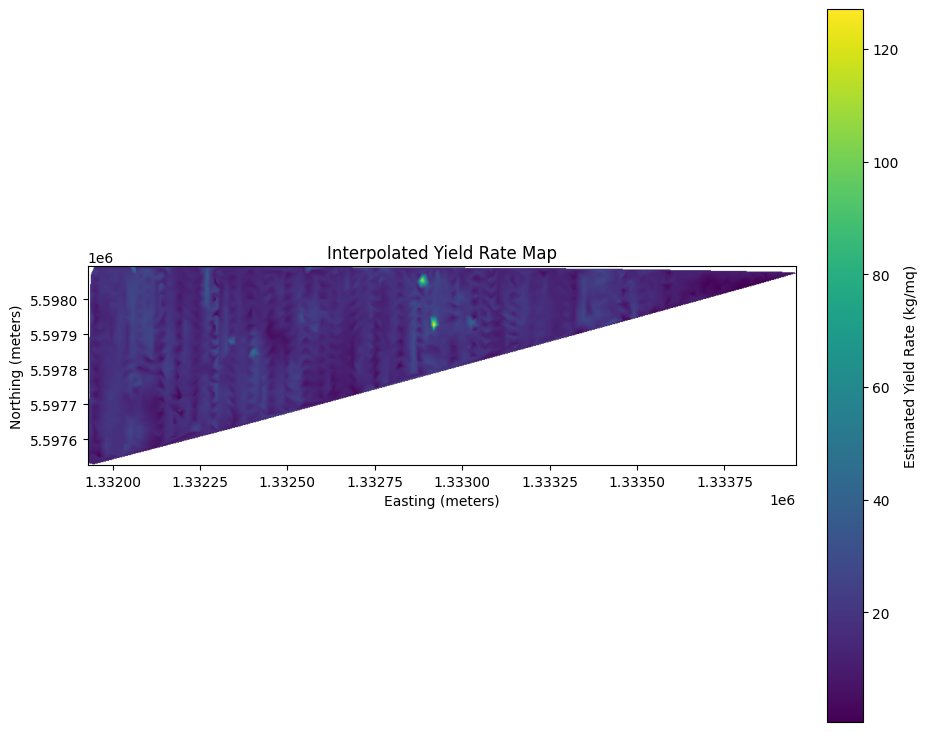

In [17]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np 

output_raster_path = 'interpolated_yield_map.tif'

with rasterio.open(output_raster_path) as src:
    # Read band 1 as a masked array (handles NoData automatically)
    raster_data_masked = src.read(1, masked=True)

    # Extent for imshow (left, right, bottom, top)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Plotting - imshow handles masked arrays
    fig, ax = plt.subplots(figsize=(10, 10))
    image = ax.imshow(raster_data_masked, # Use masked array
                          cmap='viridis',        # Choose colormap
                          extent=extent)

    # Colorbar and labels
    cbar = fig.colorbar(image, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Estimated Yield Rate (kg/mq)')
    ax.set_title('Interpolated Yield Rate Map')
    ax.set_xlabel('Easting (meters)')
    ax.set_ylabel('Northing (meters)')
    ax.set_aspect('equal', adjustable='box')
    plt.show()


In [18]:
gdf.head()

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry,x_coord,y_coord,yield_rate
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,26.58,POINT (1333142.685 5597543.903),1.333143e+06,5.597544e+06,13.357143
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,26.60,POINT (1333141.706 5597572.841),1.333142e+06,5.597573e+06,9.015084
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,28.08,POINT (1333141.672 5597604.934),1.333142e+06,5.597605e+06,10.185272
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.10,POINT (1333142.284 5597633.165),1.333142e+06,5.597633e+06,14.209165
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.10,POINT (1333142.195 5597662.213),1.333142e+06,5.597662e+06,9.428571


In [19]:
gdf['Data/Ora'].min()

'3 set 2022, 10:07:15'

In [20]:
gdf['Data/Ora'].max()

'5 set 2022, 12:23:14'

In [21]:
# ---Average Vegetation Index Map ---

# 1. Install Libraries (Run this cell once if needed)
# !pip install planetary-computer pystac-client rioxarray xarray rasterio geopandas matplotlib scipy dask distributed stackstac[visualization] # Corrected SDK name

# 2. Import Libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray # No explicit import needed, used via .rio accessor
import pystac_client
import planetary_computer as pc
import stackstac
from shapely.geometry import box
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import warnings

# Suppress specific warnings if needed (optional)
#warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=UserWarning)


# --- Step A: Define Parameters ---
print("--- Defining Parameters ---")
# 1. AOI Bounding Box (values from projected gdf)
min_x, max_x = 1331928.63, 1333951.86
min_y, max_y = 5597528.34, 5598092.76
target_crs = "EPSG:32633" # Your projected CRS (UTM Zone 33N)

# Convert projected bounds to Lat/Lon (EPSG:4326) for STAC catalog search
try:
    aoi_gdf_proj = gpd.GeoDataFrame(geometry=[box(min_x, min_y, max_x, max_y)], crs=target_crs)
    aoi_gdf_4326 = aoi_gdf_proj.to_crs("EPSG:4326")
    search_bounds_4326 = aoi_gdf_4326.total_bounds # [min_lon, min_lat, max_lon, max_lat]
    print(f"AOI Bounds (Search, EPSG:4326): {np.round(search_bounds_4326, 5)}")
except Exception as e:
    print(f"Error getting bounds for search: {e}. Please ensure target_crs is correct.")
    raise

# 2. Time Period (2022 Growing Season before Sept harvest)
start_date = '2022-04-01'
end_date = '2022-08-31'
date_range = f"{start_date}/{end_date}"
print(f"Time Period: {date_range}")

# 3. Target Resolution (Matching yield map)
resolution = 2.0 # meters
print(f"Target Resolution: {resolution}m")

# 4. Index Name
index_name = 'NDVI'
print(f"Vegetation Index: {index_name}")

# ---Setup Dask Client for Parallel Processing ---
client = None # Initialize client as None
cluster = None # Initialize cluster as None
try:
    print("\nSetting up Dask client...")
    cluster = LocalCluster() # Adjust parameters if needed (memory, workers)
    client = Client(cluster)
    print(f"Dask Dashboard: {client.dashboard_link}")
except Exception as e:
    print(f"Could not start Dask client: {e}. Proceeding without Dask parallelism.")

# --- Step B: Search for and Load Satellite Data ---
try:
    print("\nSearching for Sentinel-2 L2A data via Planetary Computer...")
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=pc.sign_inplace,
    )

    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=search_bounds_4326,
        datetime=date_range,
        query={"eo:cloud_cover": {"lt": 25}},#filter based on image properties (to get less than 25% cloud free images)
    )

    items = search.item_collection()
    print(f"Found {len(items)} Sentinel-2 scenes matching criteria.")

    if not items:
        raise ValueError("No satellite scenes found. Try adjusting dates or cloud cover.")

    # Extract integer EPSG code from the target_crs string
    try:
        # dividing the string into two parts and than getting the last value
        target_epsg_code = int(target_crs.split(':')[-1])
    except (ValueError, IndexError, AttributeError):
        raise ValueError(f"Invalid target_crs format for EPSG code extraction: '{target_crs}'")

    print(f"\nLoading Red(B04)/NIR(B08) bands using stackstac (loading RAW integers)...")
    print(f"  Target EPSG: {target_epsg_code}")
  
    # --- MODIFIED stackstac call ---
    # Take the list of desired Sentinel-2 scene
    data_cube = stackstac.stack(
        items,
        assets=["B04", "B08"],
        resolution=resolution,
        epsg=target_epsg_code,
        bounds=[min_x, min_y, max_x, max_y],
        chunksize=2048,
        # Keep integer type for raw data
        dtype="int64", # Unsigned 16-bit integer is typical for S2
        # Keep rescaling disabled
        rescale=False,
        # --- Explicitly set fill_value back to an INTEGER ---
        # Since the dtype is integer, the fill_value must also be an integer.
        # 0 is a common choice for background/nodata in integer satellite data.
        fill_value=0
    )
    print("Raw integer data loading initiated via stackstac.")
    print(data_cube) # Check structure, dtype should be int/uint

    # --- Step C: Cloud Masking (Placeholder - CRUCIAL FOR ACCURACY) ---
    print("\nWARNING: Rigorous cloud masking is SKIPPED in this example.")
    print("   Accuracy depends heavily on using cloud-free pixels.")

    # --- Calculate NDVI ---
    # Select bands (adjust if stackstac uses different names)
    try:
        # Select the raw integer bands
        red_raw = data_cube.sel(band="B04")
        nir_raw = data_cube.sel(band="B08")
    except KeyError:
        print("Warning: Could not select bands by name ('B04', 'B08'). Assuming order [Red, NIR].")
        if data_cube['band'].size == 2:
            red_raw = data_cube.isel(band=0)
            nir_raw = data_cube.isel(band=1)
        else:
            raise ValueError("Cannot determine Red and NIR bands.")

    # --- MANUALLY SCALE to Reflectance (convert to float first) ---
    #To get the actual reflectance value, applying a specific scaling factor defined in the product specifications
    print("\nApplying scaling factor (0.0001) manually...")
    scale = 0.0001
    red = red_raw.astype(np.float32) * scale
    nir = nir_raw.astype(np.float32) * scale
    print(f"Max value in scaled NIR band: {nir.max().compute()}") # Should be around or below 1.0 now

    print("Calculating NDVI...")
    epsilon = 1e-8 # Small number to prevent division by zero
    ndvi = ((nir - red) / (nir + red + epsilon)).rename(index_name)
    # Clip to valid range
    ndvi = ndvi.clip(min=-1.0, max=1.0)
    print("NDVI calculation defined.")

    # --- Step E: Calculate Average NDVI ---
    print("Calculating median NDVI over time (may take time)...")
    avg_ndvi = ndvi.median(dim="time", skipna=True).compute()
    print("Average NDVI calculation complete.")
    print(avg_ndvi)

    # --- Step F: Save Output Raster ---
    output_veg_raster_path = 'avg_ndvi_map.tif'
    print(f"\nSaving average NDVI map to: {output_veg_raster_path}")

    # Use rioxarray to write, ensuring metadata is correct
    avg_ndvi = avg_ndvi.rio.write_crs(target_crs) # Ensure CRS is set
    # Spatial dims and transform should be inherited from stackstac correctly
    avg_ndvi.rio.to_raster(output_veg_raster_path, driver="GTiff", nodata=np.nan, tiled=True, compress='LZW')
    print("Average NDVI raster saved successfully.")
    print("\n--- Task Complete ---")
    print("Proceed with the correlation code (Step 3).")

except ImportError as ie:
     print(f"Import Error: {ie}. Please ensure all required libraries are installed.")
     print("Try: pip install planetary-computer pystac-client rioxarray xarray rasterio geopandas matplotlib scipy dask distributed stackstac[visualization]") # Corrected SDK name
except Exception as e:
     print(f"\nAn error occurred during NDVI map generation: {e}")
     import traceback
     traceback.print_exc()

finally:
    # --- Close Dask Client if started ---
    if client:
        print("\nClosing Dask client...")
        client.close()
    if cluster:
       cluster.close() # Close cluster too
    print("Dask client closed.")

--- Defining Parameters ---
AOI Bounds (Search, EPSG:4326): [26.6093  49.94302 26.63813 49.9508 ]
Time Period: 2022-04-01/2022-08-31
Target Resolution: 2.0m
Vegetation Index: NDVI

Setting up Dask client...
Dask Dashboard: http://127.0.0.1:8787/status

Searching for Sentinel-2 L2A data via Planetary Computer...
Found 23 Sentinel-2 scenes matching criteria.

Loading Red(B04)/NIR(B08) bands using stackstac (loading RAW integers)...
  Target EPSG: 32633
Raw integer data loading initiated via stackstac.
<xarray.DataArray 'stackstac-7d8e4bff383cb75fc0e696ecad6442da' (time: 23,
                                                                band: 2,
                                                                y: 283, x: 1012)> Size: 105MB
dask.array<fetch_raster_window, shape=(23, 2, 283, 1012), dtype=int64, chunksize=(1, 1, 283, 1012), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 184B 2022-...
    id                     

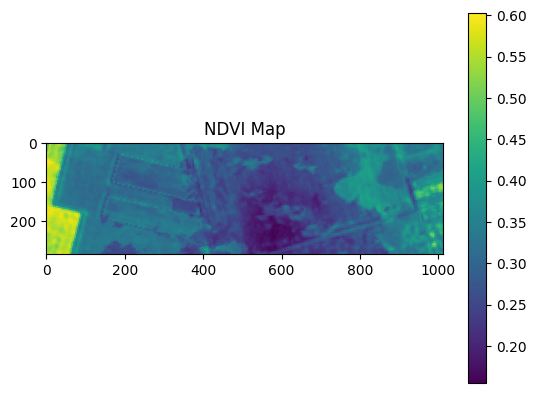

In [22]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open('avg_ndvi_map.tif') as src:
    data = src.read(1)  # Read the first band
    plt.imshow(data, cmap='viridis')
    plt.colorbar()
    plt.title("NDVI Map")
    plt.show()

In [23]:
#Comparison of Raster properties
import rasterio

# --- Use the correct filenames ---
yield_raster_path = 'interpolated_yield_map.tif' # Used the yield map saved with EPSG:32633!
avg_veg_index_raster_path = 'avg_ndvi_map.tif'

print("--- Comparing Raster Properties ---")


print(f"\n--- Properties for: {yield_raster_path} ---")
with rasterio.open(yield_raster_path) as yield_src:
    print(f"  CRS: {yield_src.crs}")
    print(f"  Bounds: {yield_src.bounds}")
    print(f"  Width: {yield_src.width}")
    print(f"  Height: {yield_src.height}")
    print(f"  Transform: {yield_src.transform}")
    # Resolution from transform: a = x_res, e = y_res (usually negative)
    print(f"  Resolution (X, Y): ({yield_src.transform.a}, {yield_src.transform.e})")
    yield_profile = yield_src.profile # Store profile for later if needed

print(f"\n--- Properties for: {avg_veg_index_raster_path} ---")
with rasterio.open(avg_veg_index_raster_path) as veg_src:
    print(f"  CRS: {veg_src.crs}")
    print(f"  Bounds: {veg_src.bounds}")
    print(f"  Width: {veg_src.width}")
    print(f"  Height: {veg_src.height}")
    print(f"  Transform: {veg_src.transform}")
    print(f"  Resolution (X, Y): ({veg_src.transform.a}, {veg_src.transform.e})")

print("\n*** Comparison of the CRS, Width, Height, and Transform values. ***")
print("*** They MUST be identical for the correlation step. ***")


--- Comparing Raster Properties ---

--- Properties for: interpolated_yield_map.tif ---
  CRS: EPSG:32633
  Bounds: BoundingBox(left=1331928.6348030185, bottom=5597526.343253597, right=1333954.6348030185, top=5598094.343253597)
  Width: 1013
  Height: 284
  Transform: | 2.00, 0.00, 1331928.63|
| 0.00,-2.00, 5598094.34|
| 0.00, 0.00, 1.00|
  Resolution (X, Y): (2.0, -2.0)

--- Properties for: avg_ndvi_map.tif ---
  CRS: EPSG:32633
  Bounds: BoundingBox(left=1331927.0, bottom=5597529.0, right=1333951.0, top=5598095.0)
  Width: 1012
  Height: 283
  Transform: | 2.00, 0.00, 1331927.00|
| 0.00,-2.00, 5598095.00|
| 0.00, 0.00, 1.00|
  Resolution (X, Y): (2.0, -2.0)

*** Comparison of the CRS, Width, Height, and Transform values. ***
*** They MUST be identical for the correlation step. ***


In [24]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

# --- Use the correct filenames ---
ref_raster_path = 'interpolated_yield_map.tif' # The reference grid (Corrected Yield Map)
src_raster_path = 'avg_ndvi_map.tif'           # The raster to align (NDVI Map)
output_aligned_raster_path = 'avg_ndvi_map_aligned.tif' # Output file path

print(f"\n--- Aligning '{src_raster_path}' to match '{ref_raster_path}' ---")

    # Open the reference raster to get its metadata (profile)
with rasterio.open(ref_raster_path) as ref_src:
    ref_profile = ref_src.profile
    ref_crs = ref_src.crs
    ref_transform = ref_src.transform
    ref_width = ref_src.width
    ref_height = ref_src.height
    print(f"Reference grid defined by '{ref_raster_path}' (CRS: {ref_crs}, Res: {ref_transform.a:.2f}x{ref_transform.e:.2f}, Dim: {ref_width}x{ref_height})")

# Open the source raster that needs alignment
with rasterio.open(src_raster_path) as src:
    # Update the output profile to match the reference raster
    out_profile = src.profile.copy()
    out_profile.update({
        'crs': ref_crs,
        'transform': ref_transform,
        'width': ref_width,
        'height': ref_height,
        'nodata': np.nan # Use NaN as nodata for the aligned float output
    })
    # Ensure output dtype is float if source wasn't already (NDVI should be)
    if not np.issubdtype(out_profile['dtype'], np.floating):
            out_profile['dtype'] = 'float32'

    print(f"Output aligned raster will be saved to '{output_aligned_raster_path}'")

    # Open the output file and perform the reprojection/resampling
    with rasterio.open(output_aligned_raster_path, 'w', **out_profile) as dst:
        print("Performing resampling/reprojection...")
        reproject(
            source=rasterio.band(src, 1),          # Input data (band 1)
            destination=rasterio.band(dst, 1),    # Output location (band 1)
            src_transform=src.transform,          # Source georeferencing
            src_crs=src.crs,                      # Source CRS
            dst_transform=ref_transform,          # Target georeferencing (from ref)
            dst_crs=ref_crs,                      # Target CRS (from ref)
            resampling=Resampling.bilinear        # Resampling method
        )
    print("Alignment complete.")
    print(f"'{output_aligned_raster_path}' will be used for the correlation step.")


--- Aligning 'avg_ndvi_map.tif' to match 'interpolated_yield_map.tif' ---
Reference grid defined by 'interpolated_yield_map.tif' (CRS: EPSG:32633, Res: 2.00x-2.00, Dim: 1013x284)
Output aligned raster will be saved to 'avg_ndvi_map_aligned.tif'
Performing resampling/reprojection...
Alignment complete.
'avg_ndvi_map_aligned.tif' will be used for the correlation step.


Reading yield raster...
Reading vegetation index raster...

Finding common valid pixels...
Extracting valid data pairs...
Found 147577 overlapping valid data points.

Calculating Pearson Correlation...

--- Correlation Results ---
Pearson Correlation Coefficient (r): -0.0537
P-value: 1.042e-94
Interpretation Hint: Indicates a Very Weak / No linear relationship.
The correlation is statistically significant (p < 0.05).

Generating scatter plot...


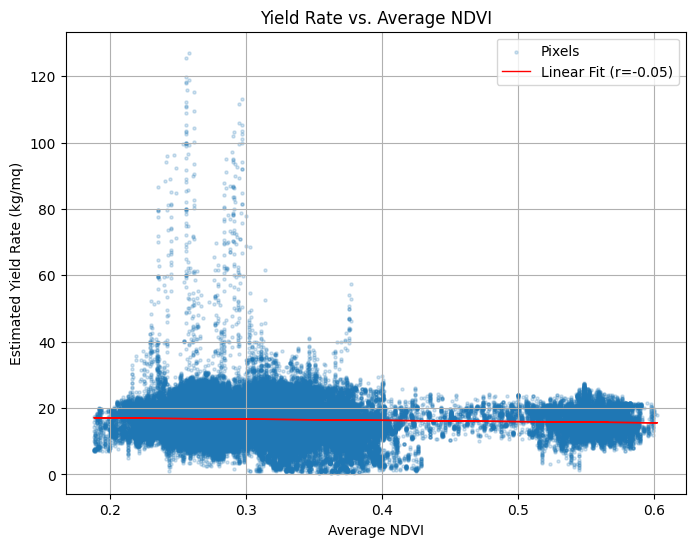

In [25]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --- Inputs ---
yield_raster_path = 'interpolated_yield_map.tif'
avg_veg_index_raster_path = 'avg_ndvi_map_aligned.tif'

# --- Read data and handle NoData using masked arrays ---
with rasterio.open(yield_raster_path) as yield_src, \
        rasterio.open(avg_veg_index_raster_path) as veg_src:

    print("Reading yield raster...") # Added feedback
    yield_masked = yield_src.read(1, masked=True) # Reads band 1, masks NoData
    print("Reading vegetation index raster...") # Added feedback
    veg_masked = veg_src.read(1, masked=True)    # Reads band 1, masks NoData

    # Optional: Basic check for shape mismatch
    if yield_masked.shape != veg_masked.shape:
            print(f"WARNING: Raster shapes do not match!")
            print(f"Yield shape: {yield_masked.shape}")
            print(f"Veg shape:   {veg_masked.shape}")
            

# --- Find common valid pixels and flatten ---
print("\nFinding common valid pixels...") # Added feedback
is_yield_valid = np.logical_not(yield_masked.mask)
is_veg_valid = np.logical_not(veg_masked.mask)
common_mask = is_yield_valid & is_veg_valid

# Apply the common mask to extract the corresponding valid data points
# These lines were missing, causing the NameError
print("Extracting valid data pairs...") # Added feedback
yield_values_flat = yield_masked[common_mask]
veg_values_flat = veg_masked[common_mask]

# --- Calculate Correlation, Print Detailed Results & Plot (Basic Check) ---

# Check the size *after* creating the arrays
num_valid_points = yield_values_flat.size # Calculate size once
print(f"Found {num_valid_points} overlapping valid data points.")

if num_valid_points >= 2: # Need >= 2 points for correlation
    # --- Calculation ---
    print("\nCalculating Pearson Correlation...") # ADDED
    # Ensure data is float for calculation if necessary (masked arrays often are)
    correlation, p_value = stats.pearsonr(yield_values_flat.astype(float), veg_values_flat.astype(float))

    # --- Detailed Results Output --- # ADDED BLOCK
    print(f"\n--- Correlation Results ---")
    print(f"Pearson Correlation Coefficient (r): {correlation:.4f}")
    print(f"P-value: {p_value:.4g}") 

    # Basic interpretation help
    if abs(correlation) >= 0.7: interpretation = "Strong" 
    elif abs(correlation) >= 0.4: interpretation = "Moderate"
    elif abs(correlation) >= 0.1: interpretation = "Weak"
    else: interpretation = "Very Weak / No"
    print(f"Interpretation Hint: Indicates a {interpretation} linear relationship.")

    # Significance check
    alpha = 0.05 # Define significance level
    if p_value < alpha:
        print(f"The correlation is statistically significant (p < {alpha}).")
    else:
        print(f"The correlation is not statistically significant (p >= {alpha}).")

    # --- Scatter Plot with Regression Line ---
    print("\nGenerating scatter plot...")
    plt.figure(figsize=(8, 6))
    plt.scatter(veg_values_flat, yield_values_flat, alpha=0.2, s=5, label='Pixels')

    # Add regression line
    # Ensure no NaN/inf values if using raw masked data before polyfit
    m, b = np.polyfit(veg_values_flat.astype(float), yield_values_flat.astype(float), 1)
    plt.plot(veg_values_flat, m*veg_values_flat + b, color='red', linewidth=1, label=f'Linear Fit (r={correlation:.2f})')

    plt.title('Yield Rate vs. Average NDVI')
    plt.xlabel('Average NDVI')
    plt.ylabel('Estimated Yield Rate (kg/mq)') # Verify units
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    # Error message using the calculated size
    print(f"\nERROR: Not enough overlapping valid data points ({num_valid_points}) found for correlation analysis.")